# Executive Summary: Retention Analysis Using SAR-Banded Risk Cells

---

## Objective
To determine an appropriate **per-life retention level (R, the amount of risk willing to retain where any risk above this threshold is ceded out)** for the portfolio in a quantifiable, risk-based manner that balances capital protection, volatility management, and reinsurance efficiency, while ensuring computational feasibility for a large block of business.

---

## Method Overview
The approach models portfolio losses under varying retention levels by grouping policies into **risk cells** (e.g. age × gender × channel × product type) and further **splitting each cell into SAR bands (SAR or sum at risk measured the per-life risk)**.  
This balances **accuracy** (captures heterogeneity of sums assured) with **runtime efficiency** (avoids full policy-by-policy simulation).

---

## Key Assumptions
- SAR within each band can be reasonably represented by the **band average**.  
- Mortality/morbidity follows a **Binomial process** with optional systemic correlation.  
- Retention applies **per life**, approximated at the SAR band level.  
- Catastrophe/pandemic multipliers applied at the cell level.

---

## Inputs Required
- **Policy exposure data**: age, gender, channel, product type.  
- **SAR distribution**: at least enough detail to construct SAR bands.  
- **Mortality/morbidity assumptions**: best estimate or stressed.  
- **Risk appetite thresholds**: capital, liquidity, concentration limits.  
- **Available capital and solvency metrics**.

---

## Advantages
- **Efficient**: avoids full policy-level simulation, enabling large portfolios to be modeled quickly.  
- **More accurate than cell averages**: SAR banding reduces bias from high-SAR outliers.  
- **Flexible**: accommodates capital, liquidity, and concentration constraints.  
- **Transparent**: easy to explain and document for internal governance and reinsurer discussions.

---

## Approach
1. **Portfolio Grouping**  
   - Create risk cells defined by mortality drivers (age, gender, channel, product type).  
   - Within each risk cell, further stratify by **SAR bands** (e.g. <10m, 10–30m, >30m).

2. **Loss Modeling**  
   - For each sub-cell:  
     - Number of policies (n)  
     - Average SAR of the band  
     - Mortality rate (q)  
     - Number of deaths: X ~ Binomial(n, q) or Beta binomail for more volatile.
     - Loss distribution: X × AvgSAR
   - Apply retention (R) per death:  
     - Retained = min(AvgSAR, R)  
     - Ceded = max(AvgSAR - R, 0)

3. **Simulation & Metrics**  
   - Aggregate retained losses across all cells under Monte Carlo scenarios.  
   - Compute portfolio metrics: **Expected Loss, Std Dev, VaR/TVaR, PML, Liquidity Stress**.  
   - Sweep retention levels **R** to identify the maximum feasible retention that satisfies **risk appetite constraints**, for example:

     - **Tail Gap (PAD-style):**  
       - **TVaR99 − VaR75 ≤ capital buffer**  
       - **TVaR99.9 − VaR75 ≤ PAD limit**  
       - **CVaR95 − VaR75 ≤ allowed adverse deviation**

     - **Pure Tail:**  
       - **VaR99 ≤ % of capital**  
       - **TVaR99.9 ≤ % of capital**  

     - **Expected Tail Loss:**  
       - **Expected loss beyond 95% (CVaR95 − EL) ≤ risk appetite**  
       - **TVaR99 − EL ≤ tail tolerance**

     - **Liquidity Tail:**  
       - **Tail cash outflow (TVaR99.9) ≤ liquidity buffer**
       
     - **Other:**  
       - Per-life retained SAR ≤ limit (e.g., THB 20m).  
       - Top cells ≤ y% of portfolio TVaR.  
       - Include reinsurer default loss in tail metric.

---

## Limitations
- **Intra-band variation**: individual SAR within a band may still exceed retention, leading to mild under/overestimation.  
- **Tail risk smoothing**: extreme single-life exposures not modeled unless carved out.  
- **Approximation bias**: assumes all policies in a band are “average,” which may distort ceded vs. retained allocation.  
- **No RI pricing**: approach focuses on **risk-based retention** only; reinsurance cost is excluded.

---

## Practical Enhancements
- **Carve-out jumbo lives** (>50m or top 100) for individual treatment.  
- **Stress testing**: apply pandemic multipliers or systematic mortality shocks.  
- **Calibration**: validate against sample policy-level runs to check approximation error.

---

## Conclusion
The SAR-banded risk cell approach provides a **practical compromise** between accuracy and tractability.  
It enables management to determine a defensible per-life retention level (R) that aligns with capital risk appetite, supports regulatory requirements, and strengthens reinsurance negotiations.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

### Upload client profile

In [2]:
uploaded = files.upload()
# Get the uploaded file name
file_name = list(uploaded.keys())[0]
# Read into DataFrame
# input = pd.read_csv(file_name)
clients = pd.read_excel(file_name, sheet_name=0)

Saving mock_client_profile.xlsx to mock_client_profile.xlsx


In [3]:
clients

,GENDER,AGE,SAR_BAND,LIFE_COUNT,SUM_SAR,SUM_SA
0,F,0,20,131,3.899398e+07,4.240384e+07
1,F,1,20,536,1.957730e+08,2.035939e+08
2,F,2,20,547,2.073400e+08,2.201761e+08
3,F,3,20,323,1.108190e+08,1.214090e+08
4,F,3,30,1,2.999370e+07,3.000000e+07
...,...,...,...,...,...,...
663,M,92,20,10,1.836504e+06,8.824229e+06
664,M,93,20,2,6.464490e+03,7.592000e+03
665,M,94,20,1,1.515105e+05,1.515105e+05
666,M,95,20,3,7.896270e+03,1.015275e+04


### Upload Mortality rate

In [4]:
uploaded = files.upload()
# Get the uploaded file name
file_name = list(uploaded.keys())[0]
# Read into DataFrame
# input = pd.read_csv(file_name)
mort = pd.read_excel(file_name, sheet_name=0)

Saving TMO2017.xlsx to TMO2017.xlsx


In [5]:
mort

,ATTAIN_AGE,M,F
0,0,0.001321,0.001058
1,1,0.000271,0.000233
2,2,0.000261,0.000228
3,3,0.000252,0.000223
4,4,0.000243,0.000218
...,...,...,...
95,95,0.311544,0.293739
96,96,0.336778,0.321487
97,97,0.363470,0.351144
98,98,0.391593,0.382689


#### Apply retention

This code applies multiple retention thresholds (20–40 million) to cap each cell’s average exposure (`AVG_SAR_noR`).  
For each threshold `r`, a new column `AVG_SAR_Rr` is created, representing the retained risk after applying the cap.  
Finally, the dataset is indexed by `CELL` for easier comparison across different retention levels.

In [6]:
df = clients.copy()

# --- Map mortality rate q into df by (GENDER, AGE) ---
mort_long = mort.melt(id_vars=["ATTAIN_AGE"], var_name="GENDER", value_name="q")
mort_long["GENDER"] = mort_long["GENDER"].str.upper().str[0]  # 'M'/'F'
df["GENDER"] = df["GENDER"].str.upper().str[0]
df = df.merge(mort_long.rename(columns={"ATTAIN_AGE": "AGE"}), on=["GENDER","AGE"], how="left", validate="m:1")

df["CELL"] = (
    df["GENDER"].astype(str).str.upper().str[0]
    + "_" + df["AGE"].astype(int).astype(str)
    + "_SAR" + df["SAR_BAND"].astype(str)
)

# Binomial distribution moments
df["mean"] = df["LIFE_COUNT"] * df["q"]
df["var"]  = df["LIFE_COUNT"] * df["q"] * (1 - df["q"])

df['AVG_SA'] = df['SUM_SA'] / df['LIFE_COUNT']
df['AVG_SAR_noR'] = df['SUM_SAR'] / df['LIFE_COUNT']

for r in [20, 25, 30, 35, 40]:
    cap = r * 1_000_000
    df[f"AVG_SAR_R{r}"] = df["AVG_SAR_noR"].clip(upper=cap)

df = df.set_index("CELL")
df


,GENDER,AGE,SAR_BAND,LIFE_COUNT,SUM_SAR,SUM_SA,q,mean,var,AVG_SA,AVG_SAR_noR,AVG_SAR_R20,AVG_SAR_R25,AVG_SAR_R30,AVG_SAR_R35,AVG_SAR_R40
CELL,,,,,,,,,,,,,,,,
F_0_SAR20,F,0,20,131,3.899398e+07,4.240384e+07,0.001058,0.138663,0.138517,3.236935e+05,2.976640e+05,2.976640e+05,2.976640e+05,2.976640e+05,2.976640e+05,2.976640e+05
F_1_SAR20,F,1,20,536,1.957730e+08,2.035939e+08,0.000233,0.125049,0.125020,3.798394e+05,3.652481e+05,3.652481e+05,3.652481e+05,3.652481e+05,3.652481e+05,3.652481e+05
F_2_SAR20,F,2,20,547,2.073400e+08,2.201761e+08,0.000228,0.124716,0.124688,4.025156e+05,3.790494e+05,3.790494e+05,3.790494e+05,3.790494e+05,3.790494e+05,3.790494e+05
F_3_SAR20,F,3,20,323,1.108190e+08,1.214090e+08,0.000223,0.071932,0.071916,3.758792e+05,3.430929e+05,3.430929e+05,3.430929e+05,3.430929e+05,3.430929e+05,3.430929e+05
F_3_SAR30,F,3,30,1,2.999370e+07,3.000000e+07,0.000223,0.000223,0.000223,3.000000e+07,2.999370e+07,2.000000e+07,2.500000e+07,2.999370e+07,2.999370e+07,2.999370e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_92_SAR20,M,92,20,10,1.836504e+06,8.824229e+06,0.242921,2.429208,1.839103,8.824229e+05,1.836504e+05,1.836504e+05,1.836504e+05,1.836504e+05,1.836504e+05,1.836504e+05
M_93_SAR20,M,93,20,2,6.464490e+03,7.592000e+03,0.265451,0.530902,0.389973,3.796000e+03,3.232245e+03,3.232245e+03,3.232245e+03,3.232245e+03,3.232245e+03,3.232245e+03
M_94_SAR20,M,94,20,1,1.515105e+05,1.515105e+05,0.287772,0.287772,0.204959,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05


## Simulate number of deaths for each risk cell

### Summary: Beta–Binomial Mortality Simulation

---

### Objective
To incorporate **systemic mortality risk** into portfolio loss modeling by allowing death probabilities within each risk cell to **fluctuate together**, producing a more realistic view of **extreme tail losses** for capital planning and PAD setting.

---

### Method Overview
The model extends the standard **Binomial** assumption (independent deaths with fixed probability *q*) by introducing a **Beta–Binomial** process:

- For each risk cell:
  - **Step 1:** Draw a mortality rate \(p\) ~ **Beta(α, β)** centered on the expected rate *q*.
  - **Step 2:** Simulate deaths ~ **Binomial(n, p)** using that drawn rate.
- This adds **systemic correlation**: lives within a cell may die together under shocks (pandemic, catastrophe).
- **Variance inflation:**  
  \[
  \mathrm{Var}[X] = n\,q(1-q)\,[1+(n-1)\rho]
  \]
  where **ρ = intra-class correlation** (ρ=0 → Binomial; ρ>0 → heavier tail).

---

### Key Insights
- Even a **small ρ** matters for large cells:  
  - \(n=1{,}000,\;ρ=0.01\) → variance ≈ **11×** Binomial.  
  - \(ρ=0.001\) → variance ≈ **2×** Binomial.
- Higher ρ ⇒ **fatter loss tail**, higher **VaR/CVaR**, and more conservative PAD.
- **ρ=0** reverts exactly to the standard Binomial model.


In [7]:
import numpy as np
import pandas as pd

def simulate_binomial_by_cell(df, n_sims=100_000, seed=42):
    """
    Rows = risk cells, Cols = iterations.
    df must have index = cell id (e.g., 'M_35_SAR40') and columns ['LIFE_COUNT','q'].
    Returns DataFrame shape (n_cells, n_sims) with same index as df.
    """
    d = df.copy()
    n = d["LIFE_COUNT"].to_numpy(dtype=np.int64)   # exposures per cell
    p = d["q"].to_numpy(dtype=float)               # mortality per cell
    p = np.clip(p, 0.0, 1.0)                       # safety clip

    rng = np.random.default_rng(seed)
    counts = rng.binomial(n=n[:, None], p=p[:, None], size=(len(d), n_sims))

    cols = [f"sim_{i+1}" for i in range(n_sims)]
    return pd.DataFrame(counts, index=d.index, columns=cols)



def simulate_beta_binomial_by_cell(df, n_sims=100_000, seed=42, rho=None, kappa=None):
    '''
    --- Parameters ---
    - n_sims : number of simulation runs (columns)
    - seed   : random seed
    - Provide exactly one of:
        • rho   (0 < rho < 1) : intra-class correlation, a parameter for how much 𝑝 can vary across simulations (ρ=0 → ordinary Binomial; ρ>0 → heavier tail).
          rho = 0.001 variance ≈ 2× binomial, rho = 0.01 variance ≈ 11× binomial
        • kappa (>0)          : Beta concentration (α+β); ρ = 1/(kappa+1)
          (large kappa → ~Binomial; small kappa → heavy tail)

    Returns:
        DataFrame (n_cells × n_sims) of simulated death counts per cell.
    '''
    d = df.copy()
    n = d["LIFE_COUNT"].to_numpy(dtype=np.int64)
    q = np.clip(d["q"].to_numpy(dtype=float), 1e-12, 1-1e-12)

    if (rho is None) == (kappa is None):
        raise ValueError("Provide exactly one of rho or kappa.")
    if rho is not None:
        if not (0 < rho < 1):
            raise ValueError("rho must be in (0,1).")
        kappa = 1.0 / rho - 1.0
    else:
        if not (kappa > 0):
            raise ValueError("kappa must be > 0.")

    alpha = q * kappa
    beta  = (1.0 - q) * kappa

    rng = np.random.default_rng(seed)
    # Draw a (cells × sims) matrix of Beta means
    P = rng.beta(alpha[:, None], beta[:, None], size=(len(d), n_sims))
    # Then Binomial with those p's
    counts = rng.binomial(n=n[:, None], p=np.clip(P, 0.0, 1.0))

    cols = [f"sim_{i+1}" for i in range(n_sims)]
    return pd.DataFrame(counts, index=d.index, columns=cols)



In [24]:
n_sims = 100000
rho = 0.00001
# death_sims_binomial = simulate_binomial_by_cell(df, n_sims=100_000, seed=42)
death_sims_beta_binomial = simulate_beta_binomial_by_cell(df, n_sims=n_sims, seed=42, rho=rho) # 1.2x binomial rho = 0.0002

In [9]:
death_sims = death_sims_beta_binomial.copy()

In [10]:
death_sims_var = death_sims.var(axis=1, ddof=0)
death_sims_var.loc["M_40_SAR20"]

np.float64(29.31074415640176)

In [11]:
df[df.index == "M_40_SAR20"]

,GENDER,AGE,SAR_BAND,LIFE_COUNT,SUM_SAR,SUM_SA,q,mean,var,AVG_SA,AVG_SAR_noR,AVG_SAR_R20,AVG_SAR_R25,AVG_SAR_R30,AVG_SAR_R35,AVG_SAR_R40
CELL,,,,,,,,,,,,,,,,
M_40_SAR20,M,40,20,10483,9.140716e+09,1.051696e+10,0.002535,26.572308,26.504953,1.003239e+06,871956.099721,871956.099721,871956.099721,871956.099721,871956.099721,871956.099721


Cheking if the death rate from simulation align with the mortality input

/tmp/ipython-input-3571591647.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


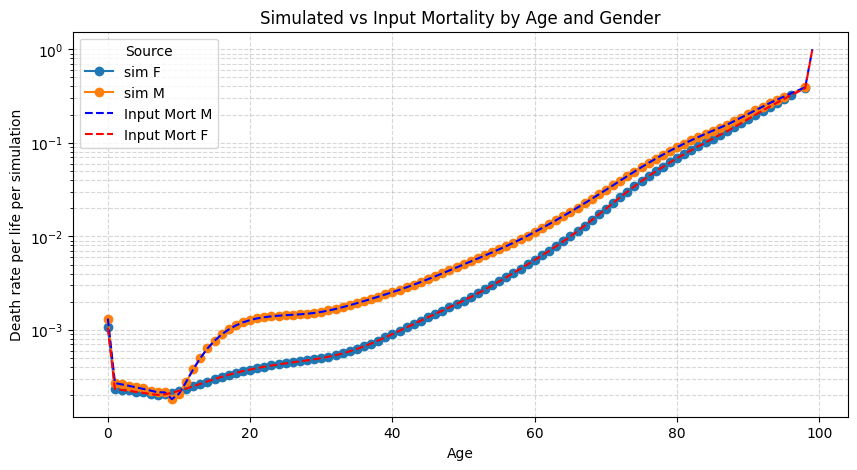

In [12]:
import matplotlib.pyplot as plt

death_sims_plt = death_sims.copy()

# --- add metadata ---
death_sims_plt["GENDER"]     = df.loc[death_sims_plt.index, "GENDER"]
death_sims_plt["AGE"]        = df.loc[death_sims_plt.index, "AGE"]
death_sims_plt["LIFE_COUNT"] = df.loc[death_sims_plt.index, "LIFE_COUNT"]

# --- totals ---
n_sims = death_sims_plt.filter(like="sim_").shape[1]
death_sims_plt["total_deaths"] = death_sims_plt.filter(like="sim_").sum(axis=1)

# total exposure = lives * number of simulations
death_sims_plt["exposure"] = death_sims_plt["LIFE_COUNT"] * n_sims

# --- aggregate by AGE & GENDER ---
agg = (
    death_sims_plt
    .groupby(["GENDER","AGE"])
    .apply(lambda x: pd.Series({
        "death_rate": x["total_deaths"].sum() / x["exposure"].sum(),
        "total_deaths": x["total_deaths"].sum()
    }))
    .reset_index()
)


# --- plot ---
plt.figure(figsize=(10,5))
for g, sub in agg.groupby("GENDER"):
    plt.plot(sub["AGE"], sub["death_rate"], marker='o', label= 'sim ' +g)

# add mortality table curves (dashed)
plt.plot(mort["ATTAIN_AGE"], mort["M"], '--', color='blue', label='Input Mort M')
plt.plot(mort["ATTAIN_AGE"], mort["F"], '--', color='red',  label='Input Mort F')

plt.xlabel("Age")
plt.ylabel("Death rate per life per simulation")
plt.title("Simulated vs Input Mortality by Age and Gender")
plt.yscale("log")  # remove if you prefer linear
plt.legend(title="Source")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()


## Expected risk amount

In [13]:
# Create dicts for each retention level
loss_sims_dict = {}
portfolio_loss_dict = {}
cell_expected_loss_dict = {}

portfolio_death = death_sims.sum(axis=0)

for r in ['noR', 'R20', 'R25', 'R30', 'R35', 'R40']:
    col = f"AVG_SAR_{r}"
    key = f"{r}"

    # deaths × SAR with this retention
    loss_sims_dict[key] = death_sims.mul(df[col], axis=0)

    # total loss per simulation
    portfolio_loss_dict[key] = loss_sims_dict[key].sum(axis=0)

    # expected loss per cell
    cell_expected_loss_dict[key] = loss_sims_dict[key].mean(axis=1)

col = "AVG_SA"
key = 'SA'

# deaths × SAR with this retention
loss_sims_dict[key] = death_sims.mul(df[col], axis=0)

# total loss per simulation
portfolio_loss_dict[key] = loss_sims_dict[key].sum(axis=0)

# expected loss per cell
cell_expected_loss_dict[key] = loss_sims_dict[key].mean(axis=1)


In [14]:
loss_sims_dict['SA']

,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,...,sim_99991,sim_99992,sim_99993,sim_99994,sim_99995,sim_99996,sim_99997,sim_99998,sim_99999,sim_100000
CELL,,,,,,,,,,,,,,,,,,,,,
F_0_SAR20,0.000,0.000,0.000,0.00,0.000000e+00,0.000000e+00,0.0,0.000,0.000,0.00,...,0.00,0.000,0.000,3.236935e+05,0.000,3.236935e+05,0.00,0.00,0.000,0.000000e+00
F_1_SAR20,0.000,0.000,0.000,0.00,0.000000e+00,0.000000e+00,0.0,0.000,0.000,0.00,...,0.00,0.000,0.000,0.000000e+00,0.000,0.000000e+00,0.00,0.00,0.000,0.000000e+00
F_2_SAR20,0.000,0.000,0.000,0.00,4.025156e+05,0.000000e+00,0.0,0.000,0.000,0.00,...,0.00,0.000,0.000,0.000000e+00,0.000,0.000000e+00,0.00,0.00,0.000,4.025156e+05
F_3_SAR20,0.000,0.000,0.000,0.00,0.000000e+00,3.758792e+05,0.0,0.000,0.000,0.00,...,0.00,0.000,0.000,0.000000e+00,0.000,0.000000e+00,0.00,0.00,0.000,0.000000e+00
F_3_SAR30,0.000,0.000,0.000,0.00,0.000000e+00,0.000000e+00,0.0,0.000,0.000,0.00,...,0.00,0.000,0.000,0.000000e+00,0.000,0.000000e+00,0.00,0.00,0.000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_92_SAR20,2647268.685,4412114.475,882422.895,1764845.79,4.412114e+06,2.647269e+06,0.0,882422.895,882422.895,3529691.58,...,1764845.79,4412114.475,2647268.685,2.647269e+06,2647268.685,2.647269e+06,0.00,3529691.58,2647268.685,1.764846e+06
M_93_SAR20,0.000,0.000,3796.000,7592.00,7.592000e+03,0.000000e+00,7592.0,0.000,0.000,3796.00,...,0.00,3796.000,0.000,3.796000e+03,3796.000,3.796000e+03,0.00,0.00,7592.000,3.796000e+03
M_94_SAR20,0.000,151510.500,0.000,0.00,0.000000e+00,1.515105e+05,151510.5,0.000,0.000,151510.50,...,151510.50,151510.500,151510.500,0.000000e+00,0.000,0.000000e+00,0.00,151510.50,151510.500,1.515105e+05


In [15]:
import numpy as np
import pandas as pd

def _tail_weights(L: np.ndarray, alpha: float) -> tuple[np.ndarray, float]:
    """Acerbi–Tasche fractional tail weights for a 1D loss array L."""
    L = np.asarray(L, dtype=float).ravel()
    S = L.size
    q = np.quantile(L, alpha, method="linear")  # VaR threshold
    target = (1.0 - alpha) * S                 # expected # of tail samples

    strict = L > q
    eq = L == q

    w = np.zeros(S, dtype=float)
    w[strict] = 1.0
    remaining = target - strict.sum()

    if remaining > 1e-12 and eq.any():
        w[eq] = min(1.0, remaining / eq.sum())

    return w, q

def summarize_losses_series(portfolio_loss: pd.Series, alphas=(0.95, 0.99, 0.999)) -> pd.Series:
    """Return EL, VAR and (VaR, CVaR) for each alpha for a single-column Series of simulations."""
    L = portfolio_loss.to_numpy(dtype=float).ravel()

    out = {
        "EL": L.mean(),
        "VAR": L.var(ddof=0),
        "STD": L.std(ddof=0),
        "#simulation": L.size,
    }

    for a in alphas:
        tag = str(int(a*1000 if a < 1 else a))  # 0.95 -> '950', 0.99 -> '990', 0.999 -> '999'
        w, q = _tail_weights(L, a)
        cvar = (L @ w) / w.sum() if w.sum() > 0 else q
        out[f"VaR{tag}"] = q
        out[f"CVaR{tag}"] = cvar

    return pd.Series(out)


In [16]:
metrics_dict = {}

for key in ['SA', "noR", "R20", "R25", "R30", "R35", "R40"]:
    # map 'noR' to your base R0 series
    # col_key = "R0" if key == "noR" else key
    metrics_dict[key] = summarize_losses_series(
        portfolio_loss_dict[key],
        alphas=(0.75, 0.95, 0.99, 0.999)
    )

metrics_dict['noR']

,0
EL,2.764038e+09
VAR,3.213245e+16
STD,1.792553e+08
#simulation,1.000000e+05
VaR750,2.878510e+09
CVaR750,3.000634e+09
VaR950,3.076569e+09
CVaR950,3.168869e+09
VaR990,3.225393e+09
CVaR990,3.305522e+09


### **Distributional Assumption for Portfolio Deaths**

* The total portfolio deaths are **theoretically Poisson–binomial** — i.e., the sum of independent Binomial\((n_i, q_i)\) variables across all cells.  
* Because the portfolio is large and each death probability \((q_i)\) is small, the **Central Limit Theorem** implies the total deaths are well-approximated by a **Normal** distribution.  
* **Normal parameters:**
  * Mean: \(\mu = \sum n_i q_i\)
  * Variance: \(\sigma^2 = \sum n_i q_i (1 - q_i)\)
* A **Poisson\((\mu)\)** approximation is also reasonable when each \((q_i)\) is very small.  
* The simulation histogram exhibits a bell-shaped curve, confirming that the **Normal approximation** fits well.


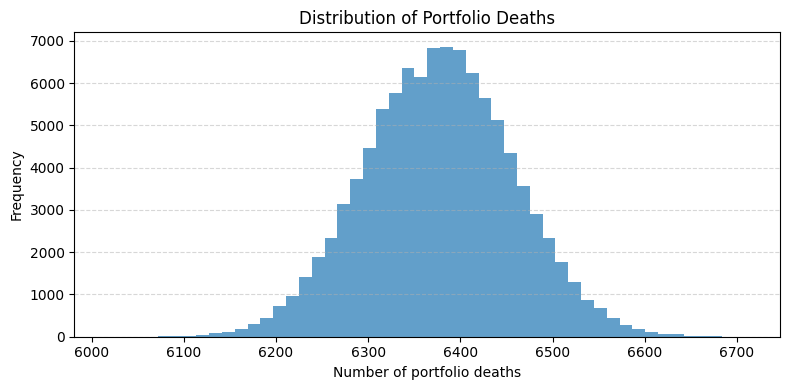

In [17]:
plt.figure(figsize=(8,4))
plt.hist(portfolio_death.values.ravel(), bins=50, alpha=0.7)
plt.xlabel("Number of portfolio deaths")
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio Deaths")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Portfolio Loss Distribution

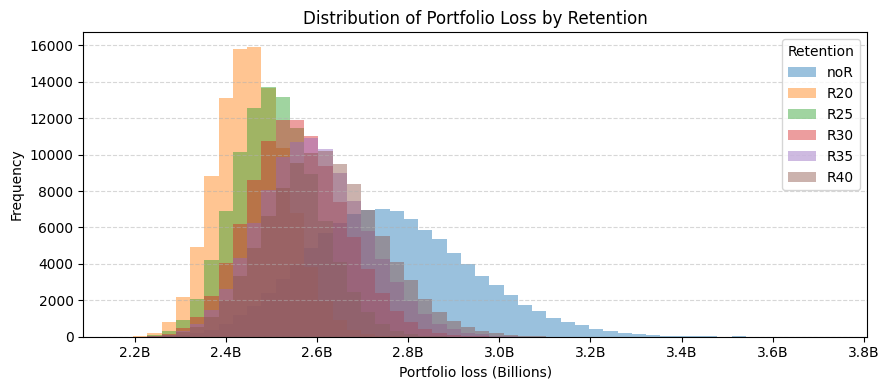

In [18]:
keys = ["noR", "R20", "R25", "R30", "R35", "R40"]

all_vals = np.concatenate([portfolio_loss_dict[k].values.ravel() for k in keys])
bins = np.histogram_bin_edges(all_vals, bins=50)

color_map = {"noR":"#1f77b4","R20":"#2ca02c","R25":"#bcbd22","R30":"#ff7f0e","R35":"#d62728"}

plt.figure(figsize=(9,4))
for k in keys:
    plt.hist(portfolio_loss_dict[k].values.ravel(), bins=bins, alpha=0.45, label=k)

plt.xlabel("Portfolio loss (Billions)")
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio Loss by Retention")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e9:.1f}B"))
plt.legend(title="Retention")
plt.tight_layout()
plt.show()

As the retention level rises, the portfolio’s loss distribution shifts rightward, reflecting the higher portion of risk being retained.


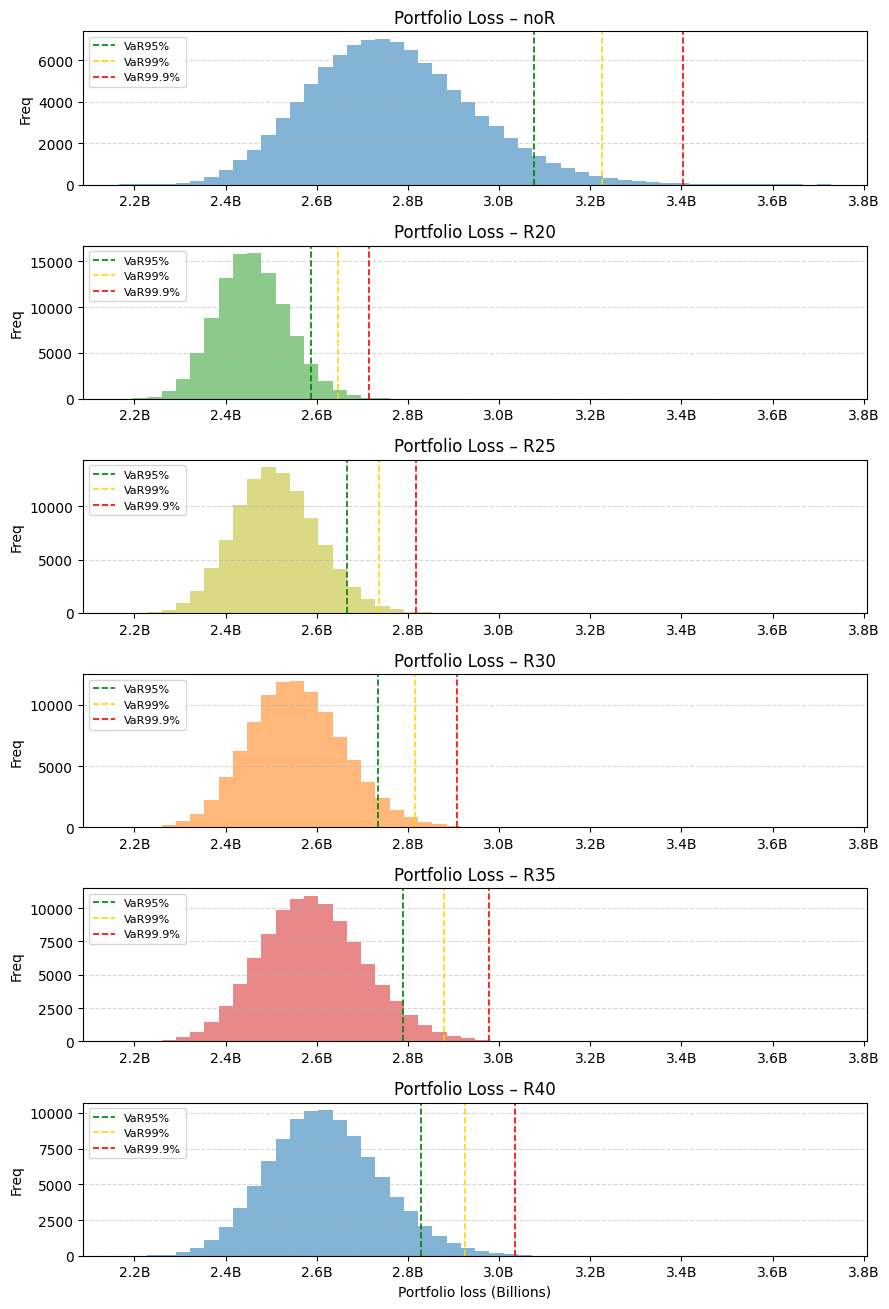

In [19]:
keys = ["noR", "R20", "R25", "R30", "R35", "R40"]

all_vals = np.concatenate([portfolio_loss_dict[k].values.ravel() for k in keys])
bins = np.histogram_bin_edges(all_vals, bins=50)
colors = {"noR":"#1f77b4","R20":"#2ca02c","R25":"#bcbd22","R30":"#ff7f0e","R35":"#d62728"}

fig, axes = plt.subplots(len(keys), 1, figsize=(9, 2.2*len(keys)), sharex=True)

for ax, k in zip(axes, keys):
    vals = portfolio_loss_dict[k].values.ravel()
    ax.hist(vals, bins=bins, alpha=0.55, color=colors.get(k,"C0"))
    ax.set_title(f"Portfolio Loss – {k}")
    ax.set_ylabel("Freq")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Show x-axis ticks on every subplot
    ax.tick_params(labelbottom=True)

    # VaR lines
    ax.axvline(metrics_dict[k]["VaR950"], color='green', linestyle='--', linewidth=1.2, label="VaR95%")
    ax.axvline(metrics_dict[k]["VaR990"], color='gold',  linestyle='--', linewidth=1.2, label="VaR99%")
    ax.axvline(metrics_dict[k]["VaR999"], color='red',   linestyle='--', linewidth=1.2, label="VaR99.9%")

    ax.legend(loc="upper left", fontsize=8, frameon=True)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e9:.1f}B"))

axes[-1].set_xlabel("Portfolio loss (Billions)")

plt.tight_layout()
plt.show()


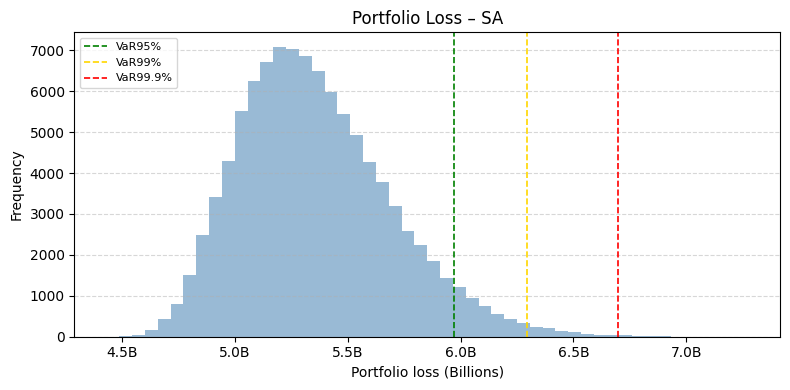

In [20]:
# pick the series
vals = portfolio_loss_dict['SA'].values.ravel()

# bins based on this series
bins = np.histogram_bin_edges(vals, bins=50)

plt.figure(figsize=(8,4))
plt.hist(vals, bins=bins, alpha=0.55, color='steelblue')
plt.title("Portfolio Loss – SA")
plt.xlabel("Portfolio loss (Billions)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# add VaR lines from metrics_dict['SA']
plt.axvline(metrics_dict['SA']["VaR950"], color='green', linestyle='--', linewidth=1.2, label="VaR95%")
plt.axvline(metrics_dict['SA']["VaR990"], color='gold',  linestyle='--', linewidth=1.2, label="VaR99%")
plt.axvline(metrics_dict['SA']["VaR999"], color='red',   linestyle='--', linewidth=1.2, label="VaR99.9%")

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e9:.1f}B"))
plt.legend(loc="upper left", fontsize=8, frameon=True)

plt.tight_layout()
plt.show()


In [21]:
# expected total deaths
exp_deaths = df["mean"].sum()

# average sum assured per life
avg_SA = df["SUM_SA"].sum() / df["LIFE_COUNT"].sum()

# average portfolio 1-year mortality rate
avg_q = (df["LIFE_COUNT"] * df["q"]).sum() / df["LIFE_COUNT"].sum()

# expected portfolio loss
exp_loss = exp_deaths * avg_SA

print(f"Expected aggregated deaths      : {exp_deaths:,.0f}")
print(f"Average portfolio SA per life   : {avg_SA:,.2f}")
print(f"Average portfolio 1-year mort q : {avg_q:.6f}")
print(f"Expected portfolio loss         : {exp_loss:,.2f}")


Expected aggregated deaths      : 6,376
Average portfolio SA per life   : 976,883.30
Average portfolio 1-year mort q : 0.005856
Expected portfolio loss         : 6,228,994,939.84


In [22]:
df

,GENDER,AGE,SAR_BAND,LIFE_COUNT,SUM_SAR,SUM_SA,q,mean,var,AVG_SA,AVG_SAR_noR,AVG_SAR_R20,AVG_SAR_R25,AVG_SAR_R30,AVG_SAR_R35,AVG_SAR_R40
CELL,,,,,,,,,,,,,,,,
F_0_SAR20,F,0,20,131,3.899398e+07,4.240384e+07,0.001058,0.138663,0.138517,3.236935e+05,2.976640e+05,2.976640e+05,2.976640e+05,2.976640e+05,2.976640e+05,2.976640e+05
F_1_SAR20,F,1,20,536,1.957730e+08,2.035939e+08,0.000233,0.125049,0.125020,3.798394e+05,3.652481e+05,3.652481e+05,3.652481e+05,3.652481e+05,3.652481e+05,3.652481e+05
F_2_SAR20,F,2,20,547,2.073400e+08,2.201761e+08,0.000228,0.124716,0.124688,4.025156e+05,3.790494e+05,3.790494e+05,3.790494e+05,3.790494e+05,3.790494e+05,3.790494e+05
F_3_SAR20,F,3,20,323,1.108190e+08,1.214090e+08,0.000223,0.071932,0.071916,3.758792e+05,3.430929e+05,3.430929e+05,3.430929e+05,3.430929e+05,3.430929e+05,3.430929e+05
F_3_SAR30,F,3,30,1,2.999370e+07,3.000000e+07,0.000223,0.000223,0.000223,3.000000e+07,2.999370e+07,2.000000e+07,2.500000e+07,2.999370e+07,2.999370e+07,2.999370e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_92_SAR20,M,92,20,10,1.836504e+06,8.824229e+06,0.242921,2.429208,1.839103,8.824229e+05,1.836504e+05,1.836504e+05,1.836504e+05,1.836504e+05,1.836504e+05,1.836504e+05
M_93_SAR20,M,93,20,2,6.464490e+03,7.592000e+03,0.265451,0.530902,0.389973,3.796000e+03,3.232245e+03,3.232245e+03,3.232245e+03,3.232245e+03,3.232245e+03,3.232245e+03
M_94_SAR20,M,94,20,1,1.515105e+05,1.515105e+05,0.287772,0.287772,0.204959,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05,1.515105e+05


In [23]:
import pandas as pd

rows = []
for k, m in metrics_dict.items():
    pad = m["CVaR999"] - m["VaR750"]
    rows.append({
        "Key"     : k,
        "EL"      : f"{int(round(m['EL'])):,}",
        "STD"     : f"{int(round(m['STD'])):,}",
        "VaR750"  : f"{int(round(m['VaR750'])):,}",
        "CVaR999" : f"{int(round(m['CVaR999'])):,}",
        "PAD"     : f"{int(round(pad)):,}"
    })

pad_df = pd.DataFrame(rows).set_index("Key")
pad_df


,EL,STD,VaR750,CVaR999,PAD
Key,,,,,
SA,"5,358,106,311","336,309,639","5,562,333,109","6,818,721,011","1,256,387,901"
noR,"2,764,038,436","179,255,253","2,878,509,719","3,474,564,169","596,054,451"
R20,"2,457,505,597","76,802,353","2,508,103,833","2,740,771,910","232,668,077"
R25,"2,511,094,172","90,921,409","2,570,531,907","2,848,327,069","277,795,162"
R30,"2,556,509,335","103,556,823","2,623,795,873","2,942,896,411","319,100,537"
R35,"2,592,604,005","114,127,502","2,666,995,921","3,020,306,495","353,310,574"
R40,"2,618,866,856","122,339,094","2,698,094,853","3,078,798,177","380,703,324"


## **Retention Optimization Analysis**

### **Objective**
To identify an optimized per-life retention level that balances portfolio volatility and capital protection, using tail risk metrics such as **VaR**, **CVaR**, and **PAD (CVaR₉₉₉ − VaR₇₅₀)**.  
This framework provides one possible approach to evaluate retention against the company’s defined **risk appetite** or **capital constraint**.

---

### **Method Summary**
- For each retention level, portfolio losses were simulated to compute the following:  
  - **EL** – Expected Loss  
  - **STD** – Standard Deviation  
  - **VaR₇₅₀** – Value at Risk at 75th percentile  
  - **CVaR₉₉₉** – Conditional Value at Risk at 99.9th percentile  
  - **PAD** – Tail gap metric defined as *(CVaR₉₉₉ − VaR₇₅₀)*  

- The **risk appetite** is defined by imposing a threshold on the tail metric — in this case, ensuring **PAD ≤ 10% of total capital**.  


---

### **Interpretation**

- The **PAD metric** increases with higher retention levels, reflecting the greater tail exposure retained by the company.  
- Given, for example, the company’s **available capital of 3,000 million**, and its tolerance that **mortality variance (PAD)** should not exceed **10% of capital (300 million)**:  
  - The **R25 scenario** shows **PAD = 277 million < 300 million**, satisfying the risk tolerance limit. A more precise retention level could be determined through linear interpolation or finer granularity; however, for simplicity, we proceed with a retention of 25 million.
  - Retentions **above 25 million** (e.g., R30, R35, R40) would exceed the risk threshold, implying excessive tail exposure.  

---

### **Conclusion**
Based on this framework, a **per-life retention of around  25 million** achieves an appropriate balance between **capital efficiency** and **tail risk control**.  
This approach can be adapted using alternative tail metrics or confidence levels to align with evolving **risk appetite frameworks** or **regulatory requirements**.
